In [4]:
%reset -f 

from typing import Tuple, Dict

from ultralytics import YOLO
from pathlib import Path
from PIL import Image

from openvino.runtime import Core, Model, serialize

from ultralytics.yolo.utils import ops
from ultralytics.yolo.utils.metrics import ConfusionMatrix
from ultralytics.yolo.utils.plotting import colors
from ultralytics.yolo.utils import DEFAULT_CFG
from ultralytics.yolo.cfg import get_cfg
from ultralytics.yolo.data.utils import check_det_dataset

import os
import cv2
import numpy as np
import torch
import nncf

os.chdir('/home/ning/Data/Dropbox/Working_Directory/trial_chute')
os.getcwd()

'/home/ning/Data/Dropbox/Working_Directory/trial_chute'

## Helper function for drawing single bounding box on image

## Parameters:
- x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
- img (no.ndarray): input image
- color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
- mask (np.ndarray, *optional*, None): instance segmentation mask polygon in format [N, 2], where N - number of points in contour, if not provided, only box will be drawn
- label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
- line_thickness (int, *optional*, 5): thickness for box drawing lines

In [5]:
def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, mask:np.ndarray = None, label:str = None, line_thickness:int = 5):
    
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1 
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA) 
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    if mask is not None:
        image_with_mask = img.copy()
        cv2.fillPoly(image_with_mask, pts=[mask.astype(int)], color=color)
        img = cv2.addWeighted(img, 0.5, image_with_mask, 0.5, 1)
    return img

## Helper function for drawing bounding boxes on image
## Parameters:

- image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
- source_image (np.ndarray): input image for drawing
- label_map; (Dict[int, str]): label_id to class name mapping



In [6]:
def draw_results(results:Dict, source_image:np.ndarray, label_map:Dict):
    
    boxes = results["det"]
    masks = results.get("segment")
    for idx, (*xyxy, conf, lbl) in enumerate(boxes):
        label = f'{label_map[int(lbl)]} {conf:.2f}'
        mask = masks[idx] if masks is not None else None 

        source_image = plot_one_box(xyxy, source_image, mask=mask, label=label, color=colors(int(lbl)), line_thickness=1)
    return source_image

### this is our test image

In [7]:
IMAGE_PATH = "./test/iroccv-t12-raisechute-labelling-20230330-022741543624_v0_00000.jpg"

### import v8x and convert the model to OpenVINO IR (you don't have to do this if you got openvino model already)

In [8]:
det_model = YOLO('./models/tiny_1280.pt')
label_map = det_model.model.names

In [9]:
det_model_path = Path("./models/tiny_1280_openvino_model/tiny_1280.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=False)

### Preprocessing

Model input is tensor with shape `[-1, 3, -1, -1]` in `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

The model expects images in RGB channels format and normalized in [0, 1] range. Although the model supports dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes e.g. 640x640 for better efficiency. To resize images to fit model size `letterbox` resize approach is used where the aspect ratio of width and height is preserved.

To keep a specific shape preprocessing automatically enables padding.

## Resize image and padding for detection. Takes image as input, 
## resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

### Parameters:
- img (np.ndarray): image for preprocessing
- new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
- color (Tuple(int, int, int)): color for filling padded area
- auto (bool): use dynamic input size, only padding for stride constrins applied
- scale_fill (bool): scale image to fill new_shape
- scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
- stride (int): input padding stride
### Returns:
- img (np.ndarray): image after preprocessing
- ratio (Tuple(float, float)): hight and width scaling ratio
- padding_size (Tuple(int, int)): height and width padding size
    

In [10]:
def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    
    shape = img.shape[:2]  
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  
        r = min(r, 1.0)

    ratio = r, r 
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1] 
    if auto:  
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  
    elif scale_fill:  
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  

    dw /= 2  
    dh /= 2

    if shape[::-1] != new_unpad:  
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color) 
    return img, ratio, (dw, dh)



## Preprocess image according to YOLOv8 input requirements. 
## Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

### Parameters:
- img0 (np.ndarray): image for preprocessing
### Returns:
- img (np.ndarray): image after preprocessing

In [11]:
def preprocess_image(img0: np.ndarray):
    
    img = letterbox(img0)[0]
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


## Preprocess image according to YOLOv8 input requirements. 
## Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

### Parameters:
- img (np.ndarray): image for preprocessing
### Returns:
- input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 

In [12]:
def image_to_tensor(image:np.ndarray):
    
    input_tensor = image.astype(np.float32) 
    input_tensor /= 255.0 
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

### Postprocessing

The model output contains detection boxes candidates, it is a tensor with shape `[-1,84,-1]` in format `B,84,N` where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has format [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`], where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of the box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting the final prediction, we need to apply a non-maximum suppression algorithm and rescale box coordinates to the original image size.

The instance segmentation model additionally has an output that contains proto mask candidates for instance segmentation, it should be decoded using box coordinates. It is a tensor with shape [-1 32, -1, -1] in format `B,C H,W` where:
- `B` - batch size
- `C` - number of candidates
- `H` - mask height
- `W` - mask width

## YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
### Parameters:
- pred_boxes (np.ndarray): model output prediction boxes
- input_hw (np.ndarray): preprocessed image
- orig_image (np.ndarray): image before preprocessing
- min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
- nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
- agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
- max_detections (int, *optional*, 300):  maximum detections after NMS
- pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
- retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
### Returns:
- pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch


In [13]:
def postprocess(
    pred_boxes:np.ndarray, 
    input_hw:Tuple[int, int], 
    orig_img:np.ndarray, 
    min_conf_threshold:float = 0.25, 
    nms_iou_threshold:float = 0.7, 
    agnosting_nms:bool = False, 
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    if pred_masks is not None:
        nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        **nms_kwargs
    )
    results = []
    proto = torch.from_numpy(pred_masks) if pred_masks is not None else None

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if not len(pred):
            results.append({"det": [], "segment": []})
            continue
        if proto is None:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append({"det": pred})
            continue
        if retina_mask:
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], shape[:2])  # HWC
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], input_hw, upsample=True)  # HWC
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            segments = [ops.scale_segments(input_hw, x, shape, normalize=False) for x in ops.masks2segments(masks)]
        results.append({"det": pred[:, :6].numpy(), "segment": segments})
    return results

### Test the OpenVino Speed on single image

In [14]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  20
  On-line CPU(s) list:   0-19
Vendor ID:               GenuineIntel
  Model name:            12th Gen Intel(R) Core(TM) i7-12700H
    CPU family:          6
    Model:               154
    Thread(s) per core:  2
    Core(s) per socket:  14
    Socket(s):           1
    Stepping:            3
    CPU max MHz:         4700.0000
    CPU min MHz:         400.0000
    BogoMIPS:            5376.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes6


## OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
### Parameters:
- image (np.ndarray): input image.
- model (Model): OpenVINO compiled model.
### Returns:
- detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]

In [15]:
core = Core()
det_ov_model = core.read_model('./models/tiny_1280_openvino_model/tiny_1280.xml')
device = "CPU" 
if device != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
    
det_compiled_model = core.compile_model(det_ov_model, device)

## our detect function

In [16]:
def detect(image:np.ndarray, model:Model):
    
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    masks = None
    if num_outputs > 1:
        masks = result[model.output(1)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image, pred_masks=masks)
    return detections

## try our openvino IR detection

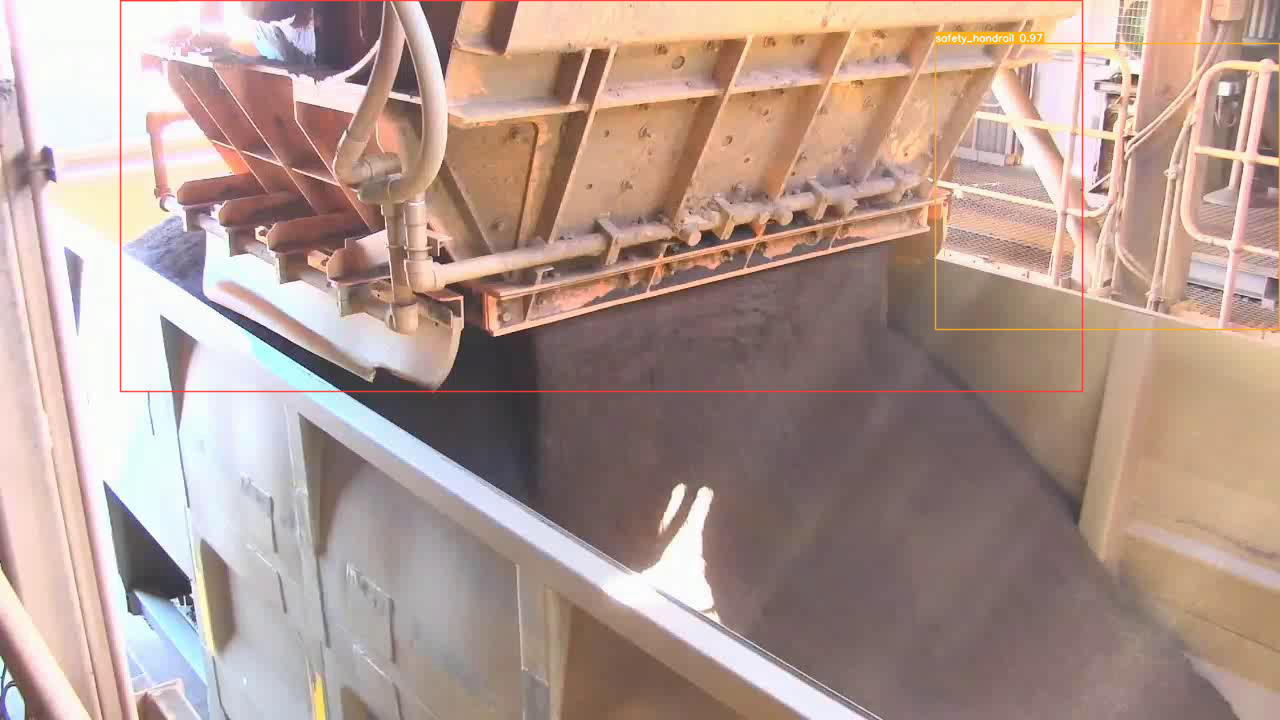

In [17]:
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

## let's time the average detection speed for openvino v8x

In [18]:
%%timeit

detections = detect(input_image, det_compiled_model)[0]

159 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
### Parameters:
- model (Model): OpenVINO model
- data_loader (torch.utils.data.DataLoader): dataset loader
- validato: instalce of validator class
- num_samples (int, *optional*, None): validate model only on specified number samples, if provided
### Returns:
- stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value

In [19]:
def test(model:Model, core:Core, data_loader:torch.utils.data.DataLoader, validator, num_samples:int = None):
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    num_outputs = len(model.outputs)
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(data_loader):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        if num_outputs == 1:
            preds = torch.from_numpy(results[compiled_model.output(0)])
        else:
            preds = [torch.from_numpy(results[compiled_model.output(0)]), torch.from_numpy(results[compiled_model.output(1)])]
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats

## Helper function for printing accuracy statistic
### Parameters:
- stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
- total_images (int) -  number of evaluated images
- total objects (int)
### Returns: 
- None

In [20]:
def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    
    print("Boxes:")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    if 'metrics/precision(M)' in stats:
        s_mp, s_mr, s_map50, s_mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
        
        s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
        print(s)
        pf = '%20s' + '%12i' * 2 + '%12.3g' * 4 
        print(pf % ('all', total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

## define our data path

In [21]:
args = get_cfg(cfg=DEFAULT_CFG)
args.data = "datasets/dataset.yaml"

det_validator = det_model.ValidatorClass(args)

## check whether there are outliers or corrupted images

In [22]:
det_validator.data = check_det_dataset(args.data)
det_data_loader = det_validator.get_dataloader("datasets/", 1)

val: Scanning datasets/coco/labels/iroccv-t12-raisechute-labelling-20230330-022741543624... 586 images, 5
val: WARNING ⚠️ Cache directory datasets/coco/labels is not writeable, cache not saved.


## Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
### Parameters:
-data_item: Dict with data item produced by DataLoader during iteration
### Returns:
-input_tensor: Input data for quantization

In [23]:
def transform_fn(data_item:Dict):
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor

## let's qunatize our yolo-x model

In [25]:
quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

ignored_scope = nncf.IgnoredScope(
    types=["Multiply", "Subtract", "Sigmoid"],  
    names=[
        "/model.22/dfl/conv/Conv",           
        "/model.22/Add",
        "/model.22/Add_1",
        "/model.22/Add_2",
        "/model.22/Add_3",
        "/model.22/Add_4",   
        "/model.22/Add_5",
        "/model.22/Add_6",
        "/model.22/Add_7",
        "/model.22/Add_8",
        "/model.22/Add_9",
        "/model.22/Add_10"
    ]
)

quantized_det_model = nncf.quantize(
    det_ov_model, 
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope
)

int8_model_det_path = Path('./models/tiny_1280_int8_vino/tiny_1280_int8_vino.xml')

print(f"Quantized detection model will be saved to {int8_model_det_path}")

serialize(quantized_det_model, str(int8_model_det_path))

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,F

## let's try the openvion IR detection with quantized yolo-x

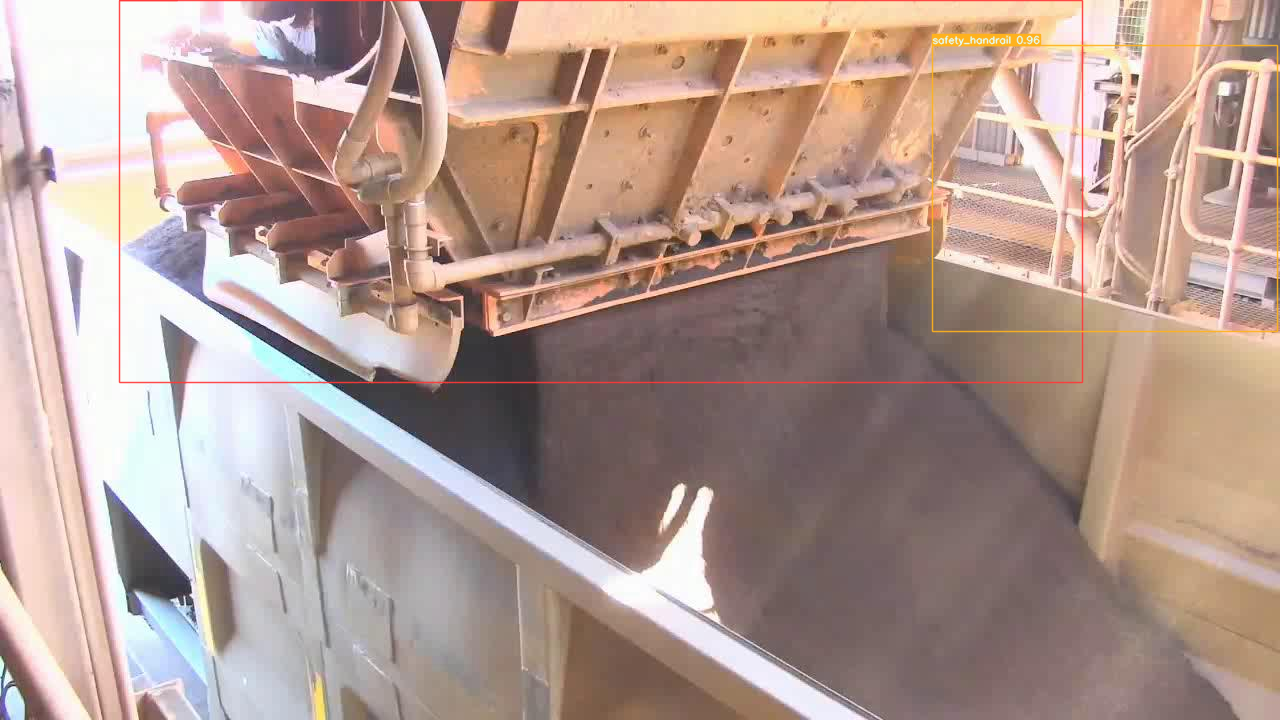

In [26]:
device = "CPU"
quantized_det_compiled_model = core.compile_model(quantized_det_model, device)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

## let's time the quantized yolo-x with openivo

In [ ]:
%%timeit

input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_det_compiled_model)[0]

87.3 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## let's qunatize our small model

In [28]:
det_ov_model = core.read_model('./models/small_640_vino/best.xml')

quantized_det_model = nncf.quantize(
    det_ov_model, 
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=ignored_scope
)

int8_model_det_path = Path('./models/small_640_int8_vino/small_640_int8_vino.xml')

print(f"Quantized detection model will be saved to {int8_model_det_path}")

serialize(quantized_det_model, str(int8_model_det_path))

INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : DefaultQuantization
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: DefaultQuantization
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithm : ActivationChannelAlignment
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Computing statistics finished
INFO:openvino.tools.pot.algorithms.quantization.default.algorithm:Start computing statistics for algorithms : MinMaxQuantization,F

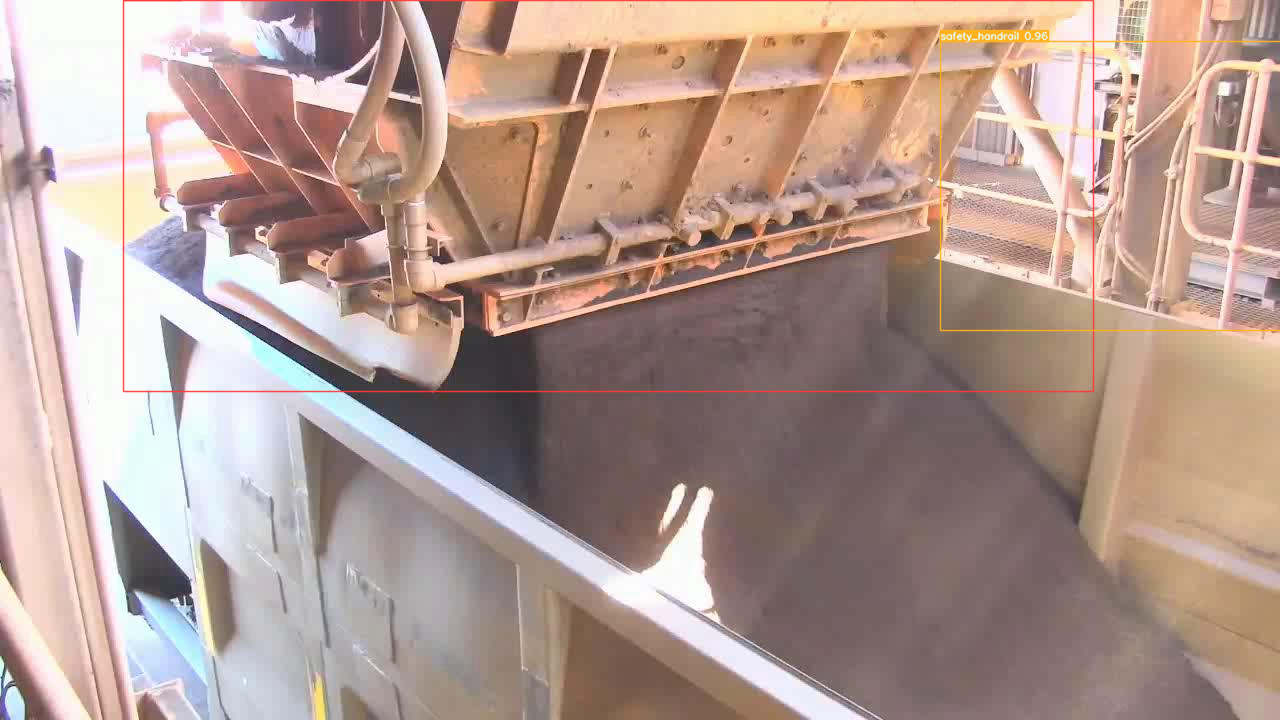

In [29]:
device = "CPU"
quantized_det_compiled_model = core.compile_model(quantized_det_model, device)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_det_compiled_model)[0]
image_with_boxes = draw_results(detections, input_image, label_map)

Image.fromarray(image_with_boxes)

In [30]:
%%timeit

input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_det_compiled_model)[0]

44.6 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
